# Import models

In [2]:
import math
import matplotlib.pyplot as plt
import torch
from lightning import LightningModule
from torch.utils.data import DataLoader
from tqdm import tqdm

from config import get_config, SentenceClassificationConfig, LLMPagConfig
from pag_classification.baseline_model import BaselineClassifier
from pag_classification.embeddings_datamodule import SentenceEmbeddingsDataModule
from pag_classification.evaluation_metrics import evaluate_robustness, accuracy_fgsm, get_accuracy
from pag_classification.pag_identity_model import PagIdentityClassifier
from pag_classification.pag_score_model import PagScoreSimilarSamplesClassifier, PagScoreSimilarFeaturesClassifier

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
llm_pag_config: LLMPagConfig = get_config('base')
sentence_classification_pag_config: SentenceClassificationConfig = get_config('sentence_classification')

In [5]:
sentences_datamodule = SentenceEmbeddingsDataModule(sentence_classification_pag_config)
sentences_datamodule.prepare_data()
sentences_datamodule.setup()
train_dataset, test_dataset = sentences_datamodule.train_dataset, sentences_datamodule.test_dataset

In [6]:
all_classifiers: dict[str, BaselineClassifier] = dict()


def instantiate_trained_classifier(classifier_name: str, clazz, **kwargs) -> BaselineClassifier:
    ckpt_dir = sentence_classification_pag_config.output_dir / f'training_{classifier_name}'
    ckpt_file = max((
        f
        for f in ckpt_dir.iterdir()
        if f.name.startswith(classifier_name) and f.name.endswith('.ckpt')
    ), key=lambda f: f.stat().st_ctime)
    print('Loading from checkpoint:', ckpt_file)

    trained_classifier = clazz.load_from_checkpoint(ckpt_file, cfg=sentence_classification_pag_config, **kwargs)
    trained_classifier.to(device)
    trained_classifier.eval()

    all_classifiers[classifier_name] = trained_classifier
    return trained_classifier

Note: **-tuned** models are the ones with the best hyperparameters for their own situation.
They include:
- number of epochs
- $\lambda$ pag and $\lambda$ cross-entropy

While the models without the `-tuned` suffix, share the same hyperparams, that are the same as the `pag-identity` best hyperparams.

In [7]:
instantiate_trained_classifier('baseline', BaselineClassifier)
instantiate_trained_classifier('pag-score-similar-samples', PagScoreSimilarSamplesClassifier,
                               train_dataset=train_dataset)
instantiate_trained_classifier('pag-score-similar-features', PagScoreSimilarFeaturesClassifier,
                               train_dataset=train_dataset)
instantiate_trained_classifier('pag-identity', PagIdentityClassifier)
# instantiate_trained_classifier('baseline-tuned', BaselineClassifier)
# instantiate_trained_classifier('pag-score-similar-samples-tuned', PagScoreSimilarSamplesClassifier,
#                                train_dataset=train_dataset)
# instantiate_trained_classifier('pag-score-similar-features-tuned', PagScoreSimilarFeaturesClassifier,
#                                train_dataset=train_dataset)
# instantiate_trained_classifier('pag-identity-tuned', PagIdentityClassifier)
;

Loading from checkpoint: checkpoints/sentence-classification/training_baseline/baseline-v2.ckpt
Loading from checkpoint: checkpoints/sentence-classification/training_pag-score-similar-samples/pag-score-similar-samples-v2.ckpt
Loading from checkpoint: checkpoints/sentence-classification/training_pag-score-similar-features/pag-score-similar-features-v2.ckpt
Loading from checkpoint: checkpoints/sentence-classification/training_pag-identity/pag-identity-v1.ckpt


''

In [8]:
print('Trained classifiers:')
for name, classifier in all_classifiers.items():
    print(f'  {name}: {classifier.__class__.__name__}')

Trained classifiers:
  baseline: BaselineClassifier
  pag-score-similar-samples: PagScoreSimilarSamplesClassifier
  pag-score-similar-features: PagScoreSimilarFeaturesClassifier
  pag-identity: PagIdentityClassifier


# Robustness evaluation

In [9]:
for name, classifier in all_classifiers.items():
    accuracy = get_accuracy(classifier, test_dataset)
    print(f'[{name}] Standard accuracy: {accuracy:.1%}')

[baseline] Standard accuracy: 70.4%
[pag-score-similar-samples] Standard accuracy: 67.5%
[pag-score-similar-features] Standard accuracy: 68.0%
[pag-identity] Standard accuracy: 70.7%


In [10]:
for name, classifier in all_classifiers.items():
    robustness = evaluate_robustness(classifier, test_dataset, attack_name='apgd-ce')
    print(f'[{name}] [APGD-CE] Robustness: {robustness:.1%}')

[baseline] [APGD-CE] Robustness: 36.5%


[pag-score-similar-samples] [APGD-CE] Robustness: 48.1%


[pag-score-similar-features] [APGD-CE] Robustness: 28.5%


[pag-identity] [APGD-CE] Robustness: 28.3%


In [11]:
for name, classifier in all_classifiers.items():
    robustness = evaluate_robustness(classifier, test_dataset, attack_name='apgd-ce', eps=0.5)
    print(f'[{name}] [APGD-CE, eps=0.5] Robustness: {robustness:.1%}')

[baseline] [APGD-CE, eps=0.5] Robustness: 31.2%


[pag-score-similar-samples] [APGD-CE, eps=0.5] Robustness: 45.0%


[pag-score-similar-features] [APGD-CE, eps=0.5] Robustness: 24.3%


[pag-identity] [APGD-CE, eps=0.5] Robustness: 25.0%


In [12]:
attack_name = 'square'
max_batches = 10

for name, classifier in all_classifiers.items():
    robustness = evaluate_robustness(classifier, test_dataset, attack_name=attack_name, max_batches=max_batches)
    print(f'[{name}] [{attack_name}] Robustness: {robustness:.1%}')

[baseline] [square] Robustness: 36.3%


[pag-score-similar-samples] [square] Robustness: 49.3%


[pag-score-similar-features] [square] Robustness: 28.9%


[pag-identity] [square] Robustness: 27.2%


In [13]:
all_fgsm_accuracies = dict()

for alpha in tqdm(torch.arange(1e-8, 5e-2, 5e-4)):
    all_fgsm_accuracies[alpha] = dict()

    for name, classifier in all_classifiers.items():
        classifier.to(device)

        real_accuracy, adv_accuracy = accuracy_fgsm(
            model=classifier,
            dataset=test_dataset,
            alpha=alpha,
        )

        all_fgsm_accuracies[alpha][name] = {
            'real_accuracy': real_accuracy,
            'adversarial_accuracy': adv_accuracy,
        }

In [21]:
for alpha in [1e-3, 5e-3, 1e-2]:
    print(f'FGSM with {alpha=}:')
    for name, classifier in all_classifiers.items():
        _, adv_accuracy = accuracy_fgsm(
            model=classifier,
            dataset=test_dataset,
            alpha=alpha,
        )
        print(f'  [{name}] Adversarial accuracy: {adv_accuracy:.1%}')
    print()

FGSM with alpha=0.001:
  [baseline] Adversarial accuracy: 60.3%
  [pag-score-similar-samples] Adversarial accuracy: 62.7%
  [pag-score-similar-features] Adversarial accuracy: 62.3%
  [pag-identity] Adversarial accuracy: 60.1%

FGSM with alpha=0.005:
  [baseline] Adversarial accuracy: 27.3%
  [pag-score-similar-samples] Adversarial accuracy: 43.5%
  [pag-score-similar-features] Adversarial accuracy: 40.1%
  [pag-identity] Adversarial accuracy: 25.7%

FGSM with alpha=0.01:
  [baseline] Adversarial accuracy: 8.9%
  [pag-score-similar-samples] Adversarial accuracy: 25.7%
  [pag-score-similar-features] Adversarial accuracy: 20.6%
  [pag-identity] Adversarial accuracy: 8.0%



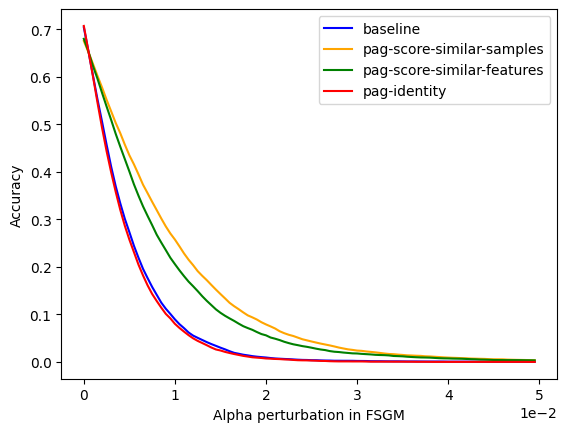

In [34]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'darkblue']

x = list(all_fgsm_accuracies.keys())

for name, color in zip(all_classifiers.keys(), colors):
    if name.endswith('-tuned'):
        continue

    y = [
        fgsm_entry[name]['adversarial_accuracy'] for fgsm_entry in all_fgsm_accuracies.values()
    ]

    plt.plot(
        x, y,
        label=name,
        color=color,
    )

plt.legend()
plt.gca().ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
plt.xlabel('Alpha perturbation in FSGM')
plt.ylabel('Accuracy');

# Plot of internals

In [41]:
from sklearn.manifold import TSNE


@torch.no_grad()
def show_logits(dataset, target_classifier: LightningModule, title: str = None, n: int = 4096, ax=None):
    dataloader = DataLoader(dataset, batch_size=n, shuffle=True)
    batch = next(iter(dataloader))
    embeddings, labels = batch['embedding'].to(device), batch['label'].cpu()

    hidden_state = embeddings
    for layer in target_classifier.classifier.classifier:
        hidden_state = layer(hidden_state)
    projected_points = hidden_state.cpu()

    if ax is None:
        ax = plt

    # Use tSNE
    tsne = TSNE(n_components=2, random_state=1)
    projected_points = tsne.fit_transform(projected_points.detach().cpu().numpy())

    for class_i in range(sentence_classification_pag_config.output_features):
        points = projected_points[labels == class_i]
        ax.scatter(points[:, 0], points[:, 1], label=f'Class {class_i}', color=colors[class_i], alpha=.1)

    ax.set_title(title)
    ax.legend()

In [42]:
rows, cols = math.ceil(len(all_classifiers) / 4.0), min(len(all_classifiers), 4)

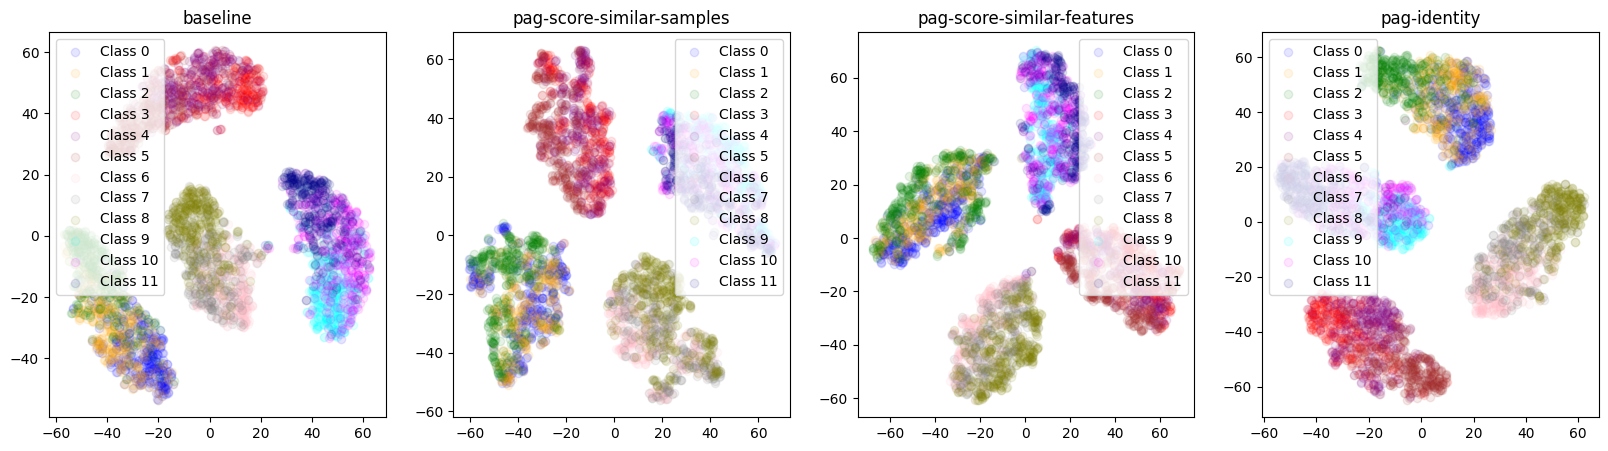

In [43]:
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
for i, (name, classifier) in enumerate(all_classifiers.items()):
    show_logits(
        dataset=test_dataset,
        target_classifier=classifier,
        title=name,
        ax=axes[i] if rows == 1 else axes[i // 4, i % 4],
    )

In [46]:
@torch.no_grad()
def show_inner_hidden_state(dataset, target_classifier: LightningModule, after_layer_idx: int, title: str = None,
                            n: int = 4096, ax=plt):
    target_classifier.eval()
    layer = target_classifier.classifier.classifier[after_layer_idx]
    print('Considering right after layer', layer)

    dataloader = DataLoader(dataset, batch_size=n, shuffle=True)
    batch = next(iter(dataloader))
    embeddings, labels = batch['embedding'].to(device), batch['label'].cpu()

    hidden_state = embeddings
    for layer in target_classifier.classifier.classifier[:after_layer_idx + 1]:
        hidden_state = layer(hidden_state)
    projected_points = hidden_state.cpu().numpy()

    if projected_points.shape[1] > 2:
        # Must apply tSNE
        tsne = TSNE(n_components=2, random_state=1)
        projected_points = tsne.fit_transform(projected_points)

    for class_i in range(sentence_classification_pag_config.output_features):
        points = projected_points[labels == class_i]
        ax.scatter(points[:, 0], points[:, 1], label=f'Class {class_i}', color=colors[class_i], alpha=.1)

    ax.set_title(title)
    ax.legend()

Considering right after layer Linear(in_features=128, out_features=12, bias=True)
Considering right after layer Linear(in_features=128, out_features=12, bias=True)
Considering right after layer Linear(in_features=128, out_features=12, bias=True)
Considering right after layer Linear(in_features=128, out_features=12, bias=True)


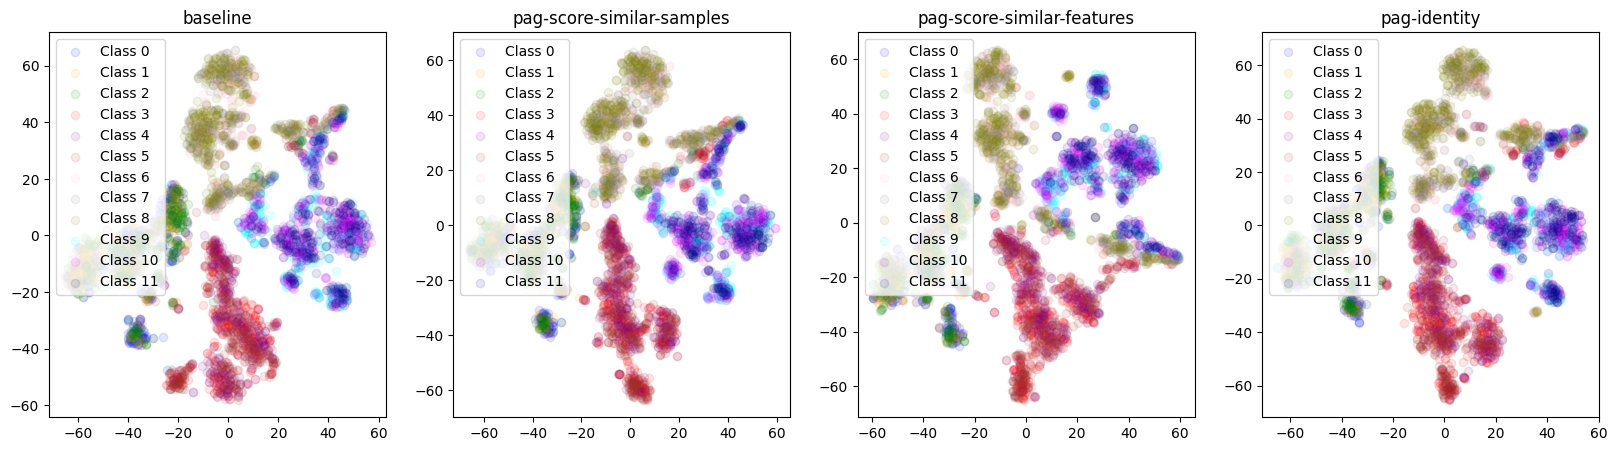

In [47]:
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
for i, (name, classifier) in enumerate(all_classifiers.items()):
    show_inner_hidden_state(
        dataset=test_dataset,
        target_classifier=classifier,
        after_layer_idx=-1,
        title=name,
        ax=axes[i] if rows == 1 else axes[i // 4, i % 4],
    )